#  MCMC sampling, Variational Inference methods

In this worksheet, you will perform approximate inference for PGMs in PyMC. 
We will employ both MCMC sampling and variational inference methods. 
You can find an overview of [MCMC sampling](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and 
[variation inference](https://www.pymc.io/projects/examples/en/latest/variational_inference/variational_api_quickstart.html) in PyMC's examples. 

Consider sample data (i=1,2,...,200) from the following Normal mixture model:
$$Z_i\in\{1,2,3\} \sim \mathcal{Cat}(\pmb{\pi}=[0.2, \; 0.3, \; 0.5])  \\ 
X_i|Z_i \sim \mathcal{N}( \mu_{Z_i}, \sigma = 1 ), \\
\quad \text{ where } \mu_1 =-4,\; \mu_2 =0,\; \mu_3 = 4$$

The following code generates and plots a sample of 200 observations from this model $$X_i=\pi_1\cdot \mathcal{N}(\mu_1,1)+\pi_2\cdot \mathcal{N}(\mu_2,1)+\pi_3\cdot \mathcal{N}(\mu_3,1)$$

In [1]:
import numpy as np

# Generate synthetic data
np.random.seed(123)
K = 3    # Number of clusters
n = 200  # Number of data points

# True parameters
pi = np.array( [0.2, 0.3, 0.5] )  # Mixing proportions
mu = np.array([-4, 0, 4])   # Means of the Gaussians
sigma = 1.0

# Generate latent variables
z = np.random.choice(K, size=n, p=pi)

# Generate observed data
x = np.random.normal(loc=mu[z], scale=sigma, size=n)

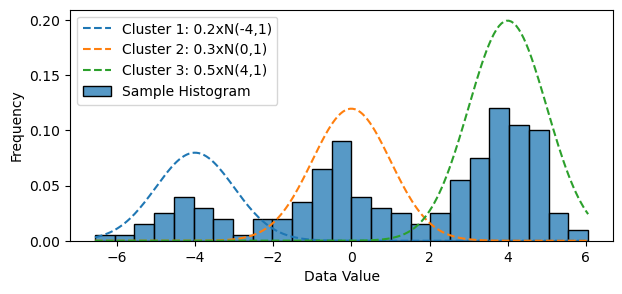

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the generated data
plt.figure(figsize=(7, 3))
sns.histplot(x, bins=25, stat = 'probability', label = "Sample Histogram") #Using seaborn for a better histogram.
plt.xlabel("Data Value"); plt.ylabel("Frequency")

# Overlay the true Gaussian clusters
x_plot = np.linspace(min(x), max(x), 200)
for i in range(K):
    plt.plot(x_plot, pi[i] * np.exp(-0.5 * ((x_plot - mu[i]) / sigma)**2) / (sigma * np.sqrt(2 * np.pi)), 
             label=f"Cluster {i+1}: {pi[i]}xN({mu[i]},1)", linestyle='--')
plt.legend();plt.show()

Let's build a *Bayesian* PGM for these data, where we treat the mixing probabilities and the cluster means as random variables. \
The cluster means ($\{\mu_i\}_{i=1,2,3}$) have i.i.d. $\mathrm{N}(0,10^2)$ priors, and the vector of probabilities ($\pmb{\pi}$) follows a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution)$([1,\,1,\,1])$ prior.   
(The Dirichlet is a multivariate distribution on a vector of categorical probabilities summing up to 1. It can be thought of as a generalization of the Beta distribution on a single probability.)\
The following `PyMC` code implements this model, using a categorical RV $Z$ to keep track of the cluster used (note that the distribution mean is chosen based on the cluster).

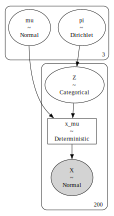

In [3]:
import pymc as pm

# Model specification
with pm.Model() as myPGM:
    # Priors for mixing proportions
    pi = pm.Dirichlet("pi", a=np.ones(K))

    # Priors for cluster means
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K)

    # Latent cluster assignments
    Z = pm.Categorical("Z", p=pi, shape=n)

    # Select mean based on latent cluster
    mu_Z = pm.Deterministic("x_mu", mu[Z])

    # Likelihood (observed data)
    X = pm.Normal("X", mu_Z, sigma=1, observed=x)

gv = pm.model_to_graphviz(myPGM)

# Resize the figure (width, height in inches or a ratio)
gv.graph_attr.update(size="5,3")  # make figure smaller (default is usually "10,8")
gv # Display the graph

## PyMC Samples

### a.simulate data 
You can simulate data from this model **without** taking into account observations (i.e., as if we did not provide the `observed=x` argument in the `X` variable definition), with the function `pm.sample_prior_predictive()`. (Altervativelly, you can extract random values from *specific subsets* of RVs in the model with the function `pm.draw()`. \
The following code creates such a sample from the model's full (all RVs) prior predictive distribution:

In [4]:
with myPGM:
    pp_sample = pm.sample_prior_predictive(samples=200) 

Sampling: [X, Z, mu, pi]


Every sampling method `PyMC` returns an [ArviZ `InferenceData` object](https://python.arviz.org/en/latest/api/inference_data.html) which is a convenient data structure for keeping track of MC sample. You can print and check the contents of the object as follow: 

In [5]:
print( type(pp_sample) )
print( pp_sample.items )
pp_sample

<class 'arviz.data.inference_data.InferenceData'>
<bound method InferenceData.items of Inference data with groups:
	> prior
	> prior_predictive
	> observed_data>


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Typically, we plot the distribution and/or calculate the means of the simulated variables. 
(For more details, see the [working with Inference Data guide](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html). The code below plots the density and calculates the mean of the *simulated* $X$ data. Note that each of the 200 $X_i$ variables is treated separately, i.e. there are 200 density lines and series plots, one for each $X_i$ in the model.

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    X        float64 8B -0.2878

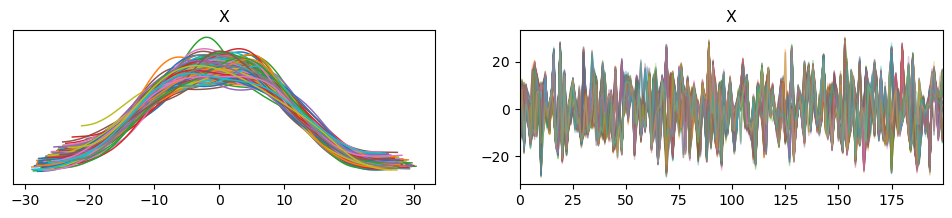

In [6]:
pm.plot_trace(pp_sample.prior_predictive['X'])  
pp_sample.prior_predictive.mean()

### b. simulate from Normal Mixture 
It is evident that the distribution of these $X_i$ variables is very different from the data we simulated originally. The reason is that the model we used to simulate the data is *not* Bayesian, i.e., the values of the mixture probabilities and the means are *not* random (they don't have a prior), but fixed.

Specify a new PGM with PyMC below which *exactly* replicates the original mixture model; use `pm.NormalMixture()` with 3 components. Then use it to simulate 200 values from $X$ and plot the inference data (the plot match the original histogram with the 3 modes).

Sampling: [X]


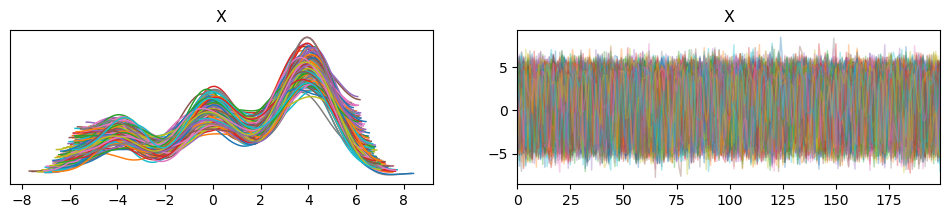

In [7]:
with pm.Model() as myMixMod:
    X = pm.NormalMixture("X", w =  np.array( [0.2, 0.3, 0.5] ),  # Mixing proportions
                         mu = np.array([-4, 0, 4]),   # Means of the Gaussians 
                         sigma = np.array([1,1,1]), observed = x)    
    MM_pp_sample = pm.sample_prior_predictive( samples=200 ) 

pm.plot_trace(MM_pp_sample.prior_predictive['X']);

Sampling: [X]


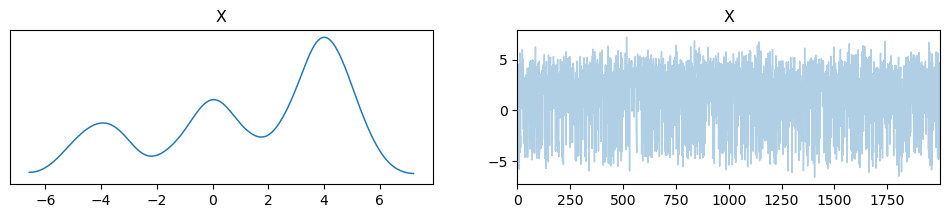

In [8]:
# Alternatively, you can choose not to specify the observed data
with pm.Model() as myMixMod:
    X = pm.NormalMixture("X", w =  np.array( [0.2, 0.3, 0.5] ),
                         mu = np.array([-4, 0, 4]),
                         sigma = np.array([1,1,1]))
    MM_sample = pm.sample_prior_predictive( samples=2000 ) 

# In this case, the trace plot will show the **prior** distribution of X (b/c the RV X is now latent)
pm.plot_trace(MM_sample.prior['X']);

## MCMC Methods

The `pm.sample()` function employs MCMC to draw samples from the *posterior* distribution of the latent variables and/or random parameters (Bayesian stats), given the data. The following code draws and plots such samples for the variables of interest, ($\pmb{\pi,\mu}$).

In [9]:
import pymc as pm
with pm.Model() as myPGM:
    pi = pm.Dirichlet("pi", a=np.ones(K)) # Priors for mixing proportions
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K)  # Priors for cluster means
    Z = pm.Categorical("Z", p=pi, shape=n) # Latent cluster assignments
    mu_Z = pm.Deterministic("x_mu", mu[Z]) # Select mean based on latent cluster
    X = pm.Normal("X", mu_Z, sigma=1, observed=x) # Likelihood (observed data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, mu]
>CategoricalGibbsMetropolis: [Z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.432,0.164,0.121,0.586,0.080,0.045,7.0,37.0,1.53
pi[1],0.330,0.135,0.118,0.562,0.066,0.032,5.0,32.0,2.41
pi[2],0.238,0.091,0.112,0.378,0.043,0.000,6.0,117.0,1.74
mu[0],1.840,3.505,-4.420,4.077,1.744,1.007,7.0,30.0,1.53
mu[1],-0.259,2.865,-4.412,4.028,1.425,0.712,5.0,29.0,2.41
mu[2],-2.286,1.953,-4.521,-0.063,0.969,0.004,6.0,140.0,1.73


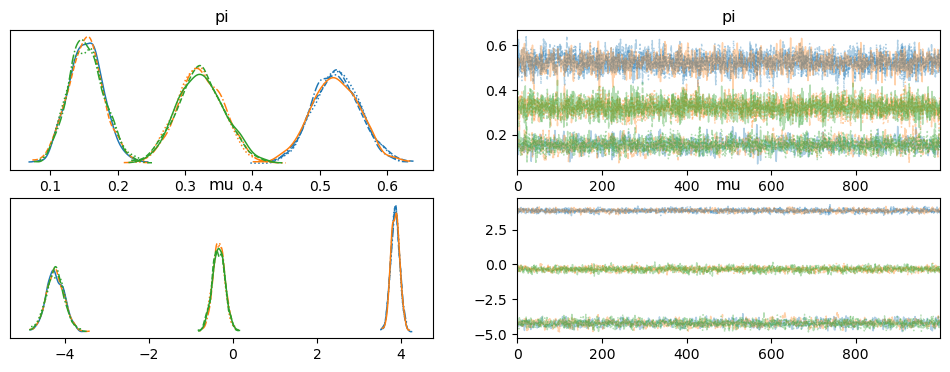

In [10]:
with myPGM:
    trace = pm.sample() 
    
pm.plot_trace(trace, var_names=['pi', 'mu'])
pm.summary(trace, var_names=['pi', 'mu'])

Note that the posterior distributions/means of the variables are centered around the true values, modulo the labels, since the cluster numbering is arbitrary (we started with the same priors for all parameter values).

The main arguments of the `sample()` function are:
- `draws`: The number of samples to draw; defaults to 1000. (These are in addition to tuning samples, below.)
- `tune`: The initial *burn-in* samples/iterations; defaults to 1000. (Samplers adjust their parameters during tuning; tuning samples are discarded by default.)
- `chains`: The number of chains to sample *in parallel*; running independent chains is important for some convergence statistics, and can also reveal multiple modes in the posterior. (If `None`, then set to number of CPU cores, or 2, whichever is larger.)

Modify the above code to run an MCMC sampler with 1 chain of 100 draws and 10 tuning samples; how do the results compare?

Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [pi, mu]
>CategoricalGibbsMetropolis: [Z]


Sampling 1 chain for 10 tune and 100 draw iterations (10 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.526,0.038,0.453,0.585,0.003,0.003,133.0,90.0,NaN
pi[1],0.324,0.031,0.275,0.386,0.003,0.002,110.0,113.0,NaN
pi[2],0.151,0.025,0.113,0.201,0.002,0.002,128.0,102.0,NaN
mu[0],3.865,0.110,3.718,4.107,0.010,0.010,156.0,77.0,NaN
mu[1],-0.374,0.125,-0.644,-0.165,0.018,0.009,47.0,113.0,NaN
mu[2],-4.261,0.218,-4.663,-3.922,0.028,0.019,56.0,78.0,NaN


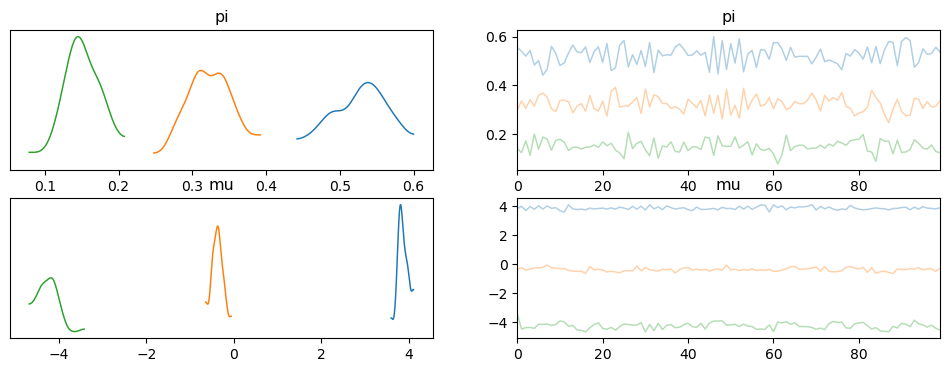

In [11]:
with myPGM:
    trace = pm.sample( draws = 100, tune = 10, chains = 1 ) 
    
pm.plot_trace(trace, var_names=['pi', 'mu'])
pm.summary(trace, var_names=['pi', 'mu'])

## Variational Inference 

Variational Inference (VI) is an alternative to MCMC that uses an analytical approximation to the posterior. Unfortunately, PyMC does not support VI for discrete RVs, as it is difficult to efficiently optimize the approximation without continuous derivatives. See also the error you get if you run the code below:

In [12]:
#with myPGM:
#    vi_approx = pm.fit() 

# ... 
# ParametrizationError: Discrete variables are not supported by VI: Z

To avoid this problem, we will reparametrize the Bayesian mixture model **without** categorical variables, using the `pm.NormalMixture()` function.

In [13]:
with pm.Model() as vi_model:
    # Priors 
    pi = pm.Dirichlet("pi", a=np.ones(K))
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K)
    # Likelihood
    X = pm.NormalMixture("X", w =  pi, mu = mu, 
                         sigma = np.array([1,1,1]), observed = x)

Variational inference proceeds with "fitting" an approximation (optimization step) and then sampling from the approximation:

Finished [100%]: Average Loss = 472.91
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.318,0.145,-0.574,-0.056,0.005,0.003,815.0,975.0,NaN
mu[1],-4.225,0.207,-4.605,-3.832,0.007,0.005,772.0,932.0,NaN
mu[2],3.833,0.099,3.637,4.005,0.003,0.002,1034.0,907.0,NaN
pi[0],0.321,0.033,0.262,0.381,0.001,0.001,819.0,716.0,NaN
pi[1],0.152,0.021,0.114,0.192,0.001,0.001,947.0,951.0,NaN
pi[2],0.527,0.047,0.439,0.611,0.002,0.001,859.0,946.0,NaN


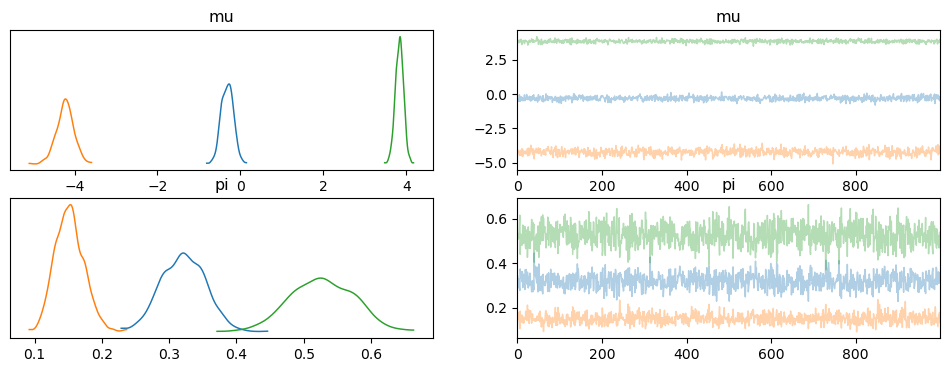

In [14]:
# ADVI inference
with vi_model:
    vi_approx = pm.fit(method="advi", obj_optimizer=pm.sgd, random_seed=123)
    vi_sample = vi_approx.sample(1000)

pm.plot_trace(vi_sample)
pm.summary(vi_sample)

As you can see, our approximation sample is very close to the (true) posterior sample from MCMC, and close to the true parameters as well. 
However, the approximation is not always guaranteed to be accurate because our optimization can get stuck in a local maximum or not converge at all.
As an example, try rerunning the previous code with the following arguments in the `pm.fit()` function:

```
vi_approx = pm.fit(method="advi", n=100, obj_optimizer=pm.sgd, random_seed=123) # different # of optimization iterations
vi_approx = pm.fit(method="advi", n=100, obj_optimizer=pm.adam, random_seed=456) # different optimization technique
```


Finished [100%]: Average Loss = 629.64
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.491,0.795,-1.967,1.055,0.025,0.018,984.0,909.0,NaN
mu[1],-3.054,0.643,-4.203,-1.868,0.025,0.014,661.0,890.0,NaN
mu[2],3.647,0.294,3.092,4.175,0.009,0.007,965.0,1026.0,NaN
pi[0],0.257,0.086,0.099,0.416,0.003,0.002,1024.0,1012.0,NaN
pi[1],0.206,0.066,0.092,0.329,0.002,0.002,1061.0,808.0,NaN
pi[2],0.537,0.127,0.293,0.764,0.004,0.002,1075.0,913.0,NaN


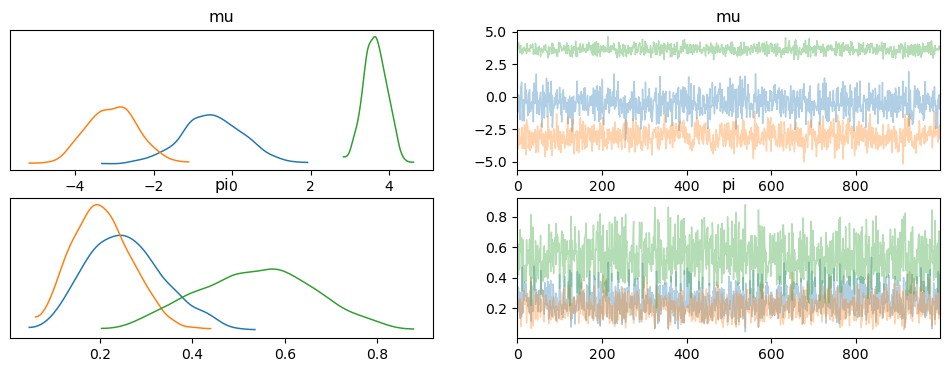

In [15]:
with vi_model:
    vi_approx = pm.fit(method="advi", n=100, obj_optimizer=pm.sgd, random_seed=123)
    vi_sample = vi_approx.sample(1000)
    
pm.plot_trace(vi_sample)
pm.summary(vi_sample)

Finished [100%]: Average Loss = 1,195.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.012,0.681,-1.312,1.237,0.020,0.015,1162.0,995.0,NaN
mu[1],0.050,0.726,-1.222,1.489,0.024,0.017,932.0,766.0,NaN
mu[2],0.022,0.736,-1.397,1.347,0.026,0.018,811.0,641.0,NaN
pi[0],0.322,0.184,0.019,0.645,0.006,0.004,965.0,850.0,NaN
pi[1],0.329,0.188,0.026,0.671,0.006,0.004,1050.0,975.0,NaN
pi[2],0.349,0.245,0.012,0.796,0.008,0.005,1004.0,944.0,NaN


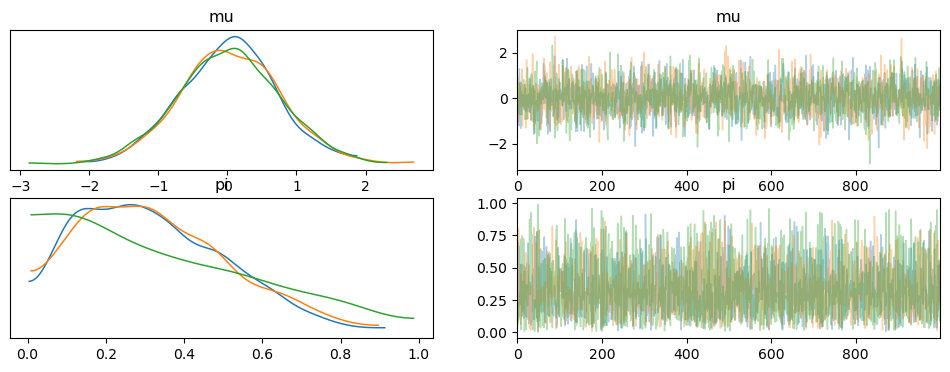

In [16]:
with vi_model:
    vi_approx = pm.fit(method="advi", n=100, obj_optimizer=pm.adam, random_seed=123)
    vi_sample = vi_approx.sample(1000)

pm.plot_trace(vi_sample)
pm.summary(vi_sample)